In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import cv2 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_dir = ("/content/drive/MyDrive/machine learning projects/training set/xray_dataset_covid19/train")
test_dir = ("/content/drive/MyDrive/machine learning projects/training set/xray_dataset_covid19/test")
classes_train =os.listdir(train_dir)
classes_test =os.listdir(test_dir)
classes_train

['PNEUMONIA', 'NORMAL']

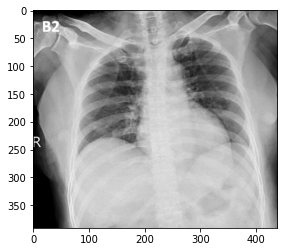

In [3]:
plt.imshow(cv2.imread("/content/drive/MyDrive/machine learning projects/training set/xray_dataset_covid19/train/PNEUMONIA/1-s2.0-S1684118220300682-main.pdf-003-b2.png"))

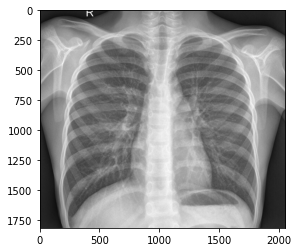

In [4]:
plt.imshow(cv2.imread("/content/drive/MyDrive/machine learning projects/training set/xray_dataset_covid19/train/NORMAL/IM-0007-0001.jpeg"))

In [5]:
train_datagen=ImageDataGenerator(
    #zoom_range=0.2, #the amount of zooming u need
    horizontal_flip=True, # Make a horizontal copy of image
    rescale=1/255, # Normalize the new images
    width_shift_range=0.10, # The percentage of Width shifitning
    height_shift_range=0.10, # The percentage of height shifitning
    shear_range=0.1, #Shear angle in counter-clockwise direction in degrees
    fill_mode='nearest',
    rotation_range=20, 
)
train_generator=train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size= 16,
    target_size=(1000,1000,3)[:2]
)

test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    class_mode='binary',
    color_mode='rgb',
    batch_size=16,
    target_size=(1000,1000,3)[:2]
)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [6]:
earlystop=EarlyStopping(patience=6)
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_acc',  #'val_loss'를 입력하면 val_loss가 더이상 감소되지 않을 경우 EarlyStopping을 적용합니다.
    patience= 3,
    verbose=1,  #0 또는 1. 1일 경우, EarlyStopping이 적용될 때, 화면에 적용되었다고 나타냅니다.0일 경우, 화면에 나타냄 없이 종료합니다
    factor=0.5,
    min_lr=0.00001
)
callbacks = [earlystop, learning_rate_reduction]

In [7]:
model=Sequential() 

model.add(Conv2D(32,(2,2),activation='relu',input_shape=(1000,1000,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(3,3))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))

model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam' ,loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 999, 999, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 499, 499, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 498, 498, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 166, 166, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 164, 164, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 128)      0

In [9]:
model.fit(
    train_generator, 
    epochs=14,
    validation_data=test_generator,
    callbacks=callbacks
)

Epoch 1/14
10/10 [==============================] - 256s 24s/step - loss: 1.4839 - accuracy: 0.5946 - val_loss: 0.6623 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/14
10/10 [==============================] - 229s 22s/step - loss: 0.6161 - accuracy: 0.7095 - val_loss: 0.2261 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/14
10/10 [==============================] - 229s 22s/step - loss: 0.4470 - accuracy: 0.8041 - val_loss: 0.0824 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/14
10/10 [==============================] - 228s 23s/step - loss: 0.4624 - accuracy: 0.8243 - val_loss: 0.1447 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/14
10/10 [==============================] - 233s 23s/step - loss: 0.3227 - accuracy: 0.8514 - val_loss: 0.0743 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/14
10/10 [==============================] - 228s 22s/step - loss: 0.2987 - accuracy: 0.8446 - val_loss: 0.0707 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/14
10/10 [==============================] - 234s 22s/step - lo

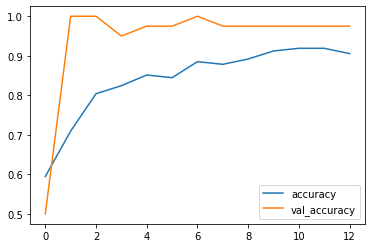

In [10]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()

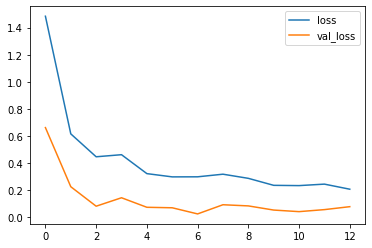

In [11]:
losses[['loss','val_loss']].plot()

In [12]:
model.evaluate(test_generator)

3/3 [==============================] - 14s 4s/step - loss: 0.0789 - accuracy: 0.9750


[0.0788792222738266, 0.9750000238418579]

In [13]:
real = test_generator.classes
real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [14]:
predictions = model.predict_generator(test_generator) > 0.5
predictions

array([[False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False]])

AxesSubplot(0.241667,0.125;0.503333x0.755)
report :               precision    recall  f1-score   support

           0       0.43      0.45      0.44        20
           1       0.42      0.40      0.41        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



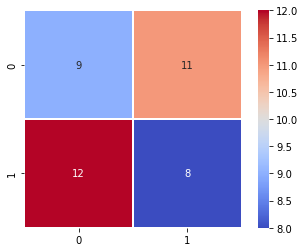

In [15]:
con = confusion_matrix(real, predictions)
print(sns.heatmap(con,cmap="coolwarm" ,annot=True,fmt="d",linewidths=1 ,square= True))
print('report :',classification_report(real, predictions ))

In [16]:
predict_path='/content/drive/MyDrive/machine learning projects/training set/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0059-0001.jpeg'
my_image = image.load_img(predict_path,target_size=(1000,1000,3))

In [17]:
my_image = np.expand_dims(my_image,axis = 0)

In [18]:
np.argmax(model.predict(my_image))

0